<a href="https://colab.research.google.com/github/Dots11/DavesProjects/blob/master/10_time_series_forecasting_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time series forecasting fundamentals with tensorFlow + Milestone Project 3: BitPredict

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.:

**Note** This is not financial advice.

Links: 
* All resources in GitHub: https://github.com/mrdbourke/tensorflow-deep-learning
* Book version of actual code/text: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/

## Get data

We are going to use the historical price data of Bitcoin to try and predict; the future price of Bitcoin, we downloaded the data from here: https://coinbase.com/price/bitcoin

In [ ]:
# Importing data from 05-18-2021
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-10-29 15:48:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.003s  

2022-10-29 15:48:30 (54.2 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



## Importing and plot time series data with Panda's CSV module

In [ ]:
# Importing time series with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the data
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1",
                 parse_dates = ["Date"],
                 index_col = ["Date"]) # parse the date column, and tell pandas column 1 is datetime
df.head() # earliest data

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


**Note:** tensorflow likes float32, numpy prefers float64

In [ ]:
df.tail() # recent data

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [ ]:
# How many samples do we have?
len(df)

2787

In [ ]:
8*365 # shy of 8 years of data

2920

We've collected the historical price of Bitcoin for the past ~8 years, but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots can be thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> **Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

In [ ]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


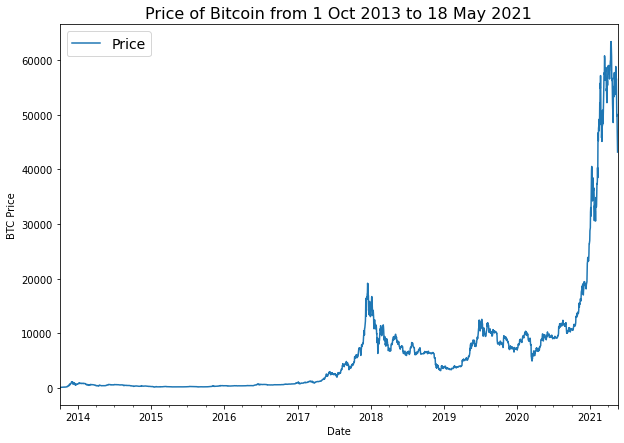

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14)

## Importing and plot time series data with Python's CSV module (Way 2)

In [ ]:
import csv
from datetime import datetime
timesteps = []
btc_price = []
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1', "r") as f:
    csv_reader = csv.reader(f, delimiter = ",")
    next(csv_reader) # skips the header when we are reading the csv in, gets rid of the column titles and straight into the data
    for line in csv_reader:
      #timesteps.append(line[1])
      timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not as strings)
      btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

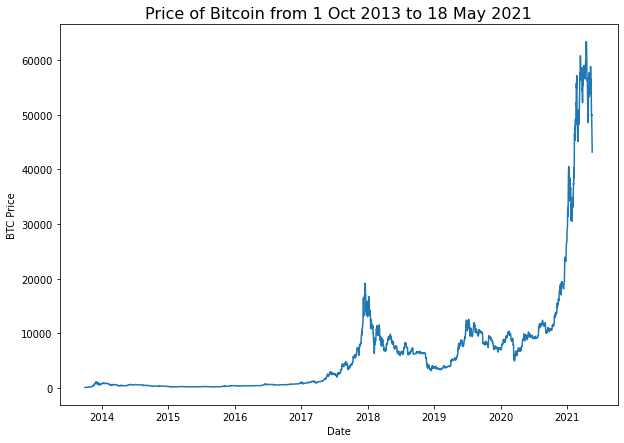

In [ ]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")

## Format data part : Create train and test sets of our time series data (the wrong way).

In [ ]:
bitcoin_prices[:5]

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy() # turning date to numpy
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # BTC prices
                                                    test_size = 0.2, # 20 percent split
                                                    random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

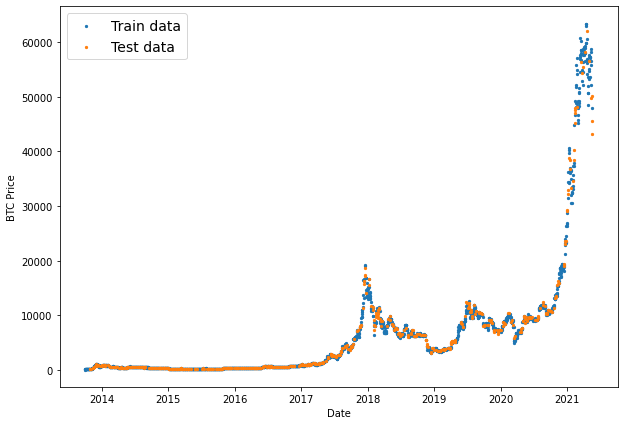

In [ ]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s = 5, label = "Train data")
plt.scatter(X_test, y_test, s = 5, label = "Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize = 14)
plt.show();

> This does not work, the random split has caused data leakage issues

### Create train & test sets for time series (the right way)

In [ ]:
# Create train and test splits on our data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you can change these values as you wish

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

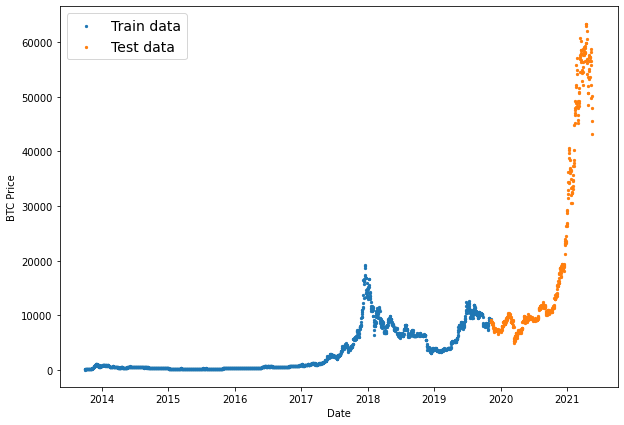

In [ ]:
# Plot correctly made splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s = 5, label = "Train data")
plt.scatter(X_test, y_test, s = 5, label = "Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize = 14)
plt.show();

## Create a plotting function
Typing plotting code is tedious, let's functionalize it.

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format = ".", start = 0, end = None, label = None):
  """
  Plots timesteps (a series of points in time) against values (a seres of values across timesteps).
  
  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps and values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize = 14) # Make label bigger
  plt.grid(True)

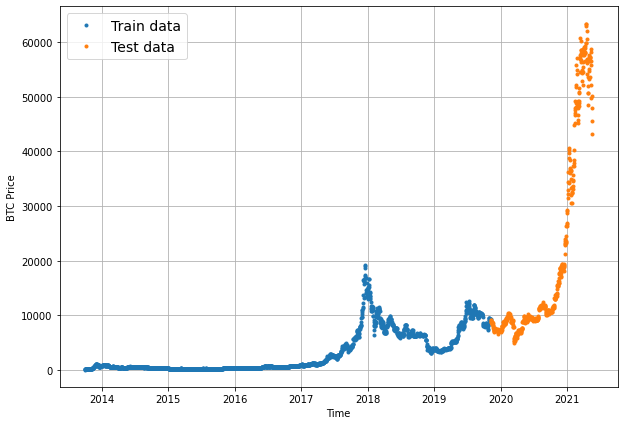

In [ ]:
# Test out plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps = X_train, values = y_train, label = "Train data")
plot_time_series(timesteps = X_test, values = y_test, label = "Test data")

# We are adding two plots to the one figure

## Modelling experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best

* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**


Modellling experiments we're running: 
* 0 	Naïve model (baseline)
* 1 	Dense model, horizon = 1, windows = 7
* 2 	Same as 1, horizon = 1, windows = 30
* 3 	Same as 1, horizon = 7, windows = 30
* 4 	Conv1D
* 5 	LSTM
* 6 	Same as 1 (but with multivariate data) 
* 7 	N-BEATs Algorithm
* 8 	Ensemble (multiple models optimized on different loss functions)
* 9 	Future prediction model (model to predict future values)
* 10 	Same as 1 (but with turkey 🦃 data introduced)

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [ ]:
y_test[:10]

array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
       8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
       8500.64355816, 8469.2608989 ])

In [ ]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]


(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [ ]:
y_test[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361, 43144.47129086])

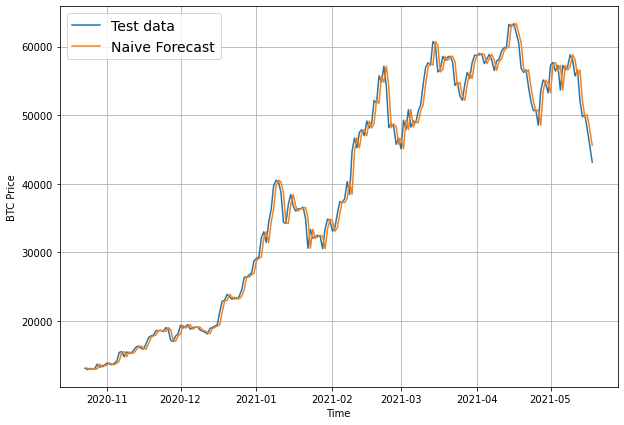

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10,7))
#plot_time_series(timesteps= X_train, values = y_train, label = "Train data")
plot_time_series(timesteps = X_test, values = y_test, start = 350, format = "-", label = "Test data")
plot_time_series(timesteps = X_test[1:], values = naive_forecast, start = 350, format = "-", label = "Naive Forecast")

In [ ]:
# There is a shift here because the Naive Forecast is predicting the next timesteps price to be the previous timestep price.

> Exercise: spend a few minutes reading the simple forecasts chapter of forecasting: Principles in Practice, and search why the naive forecast is hard to beat, does the term autoregressive come up?

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):

* MAE - mean absolute error
* MSE - mean squared error
* RMSE - Root mean squared error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?** [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html)


In [ ]:
import tensorflow as tf

In [ ]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1) e.g. bitcoin 1 value a day

  return mae/mae_naive_no_season

In [ ]:
mean_absolute_scaled_error(y_true = y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

David's Work

In [ ]:
def evaluate_preds(y_true, y_pred, dict):
  """
  Evaluating our preds through several regression metrics:

    MAE - mean absolute error
    MSE - mean squared error
    RMSE - Root mean squared error
    MAPE/sMAPE - (symmetric) mean absolute percentage error
    MASE - mean absolute scaled error
  """
  dict = {"MAE" : mae,
          #b: "MSE",
          #c: "RMSE",
          #d: "MAPE/sMAPE",
          #"MASE" : mae/mae_naive_no_season
          }
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  if dict == "MAE":
    return mae


  # # Find MAE of naive forecast (no seasonality)
  # mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1) e.g. bitcoin 1 value a day

  # return mae/mae_naive_no_season

ZTM's Work

In [ ]:
# Create a function to tae in model r predictions and truth values and return evaluation metrics

def evaluate_preds(y_true, y_pred):
  # Make sure float 32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype = tf.float32) # This is how it's done
  y_pred = tf.cast(y_pred, dtype = tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae" : mae.numpy(),
          "mse" : mse.numpy(),
          "rmse" : rmse.numpy(),
          "mape" : mape.numpy(),
          "mase" : mase.numpy()}


  

That's one good looking evalaution function
Let's see if it works

In [ ]:
naive_results = evaluate_preds(y_true = y_test[1:], y_pred = naive_forecast) # index on the y_test so that they are the same shape.
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [ ]:
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [ ]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737222>

In [ ]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Other models you can use for baselines and for actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

## Format Data Part 2: Windowing our Dataset

Why do we Window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0,1,2,3,4,5,6] -> [7]
[1,2,3,4,5,6,7] -> [8]
[2,3,4,5,6,7,8] -> [9]

*   List item
*   List item



```

In [ ]:
len(y_train)

2229

In [ ]:
btc_price[:10]

[123.65499,
 125.455,
 108.58483,
 118.67466,
 121.33866,
 120.65533,
 121.795,
 123.033,
 124.049,
 125.96116]

In [ ]:
# What we want to do with our bitcoin data

print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [ ]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon = HORIZON):
  """
  Create labels for windowed dataset.

  e.g. if horizon = 1
  Input: [0,1,2,3,4,5,6,7] -> Output: ([0,1,2,3,4,5,6], [7]) # a tuple cutting off the last value (equalling the size of the horizon)
  """
  return x[:, :-horizon], x[:, -horizon:] # get the rows up to the '-horizon' (for the windows), and then return a tuple with the negative horizon (horizon)

In [ ]:
# Test out the windows labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis = 0)) # Note: 'tf.range(8) +1' as it starts from '0'
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


In [ ]:
tf.expand_dims(tf.range(8), axis = 0)

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing - https://numpy.org/doc/stable/user/basics.indexing.html or https://www.w3schools.com/python/numpy/numpy_array_indexing.asp

Our function will:
1. Create a window step of specific window size (e.g. [0,1,2,3,4,5,6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:

```
[[0,1,2,3,4,5,6],
[1,2,3,4,5,6,7],
[2,3,4,5,6,7,8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.

> **Resource:** The function we're about to create has been adapted from the following article:
https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [ ]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size = WINDOW_SIZE, horizon = HORIZON): #'x' is our input time series

  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with a horizon size labels.
  """
  #1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis = 0)

  #2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon -1)), axis = 0).T # transpose ".T" to create 2D array of windows of size window_size
  
  # we minus the len(x) by windows size + horizon-1 to avoid the window sliding off beyond the end edge.

  print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

  #3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  # print(windowed_array)

  #4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon = horizon)
  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

Window indexes:
 (array([[   0,    1,    2, ...,    5,    6,    7],
       [   1,    2,    3, ...,    6,    7,    8],
       [   2,    3,    4, ...,    7,    8,    9],
       ...,
       [2777, 2778, 2779, ..., 2782, 2783, 2784],
       [2778, 2779, 2780, ..., 2783, 2784, 2785],
       [2779, 2780, 2781, ..., 2784, 2785, 2786]]), (2780, 8))


(2780, 2780)

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window {full_windows[i]} -> Label {full_labels[i]}")

Window [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label [123.033]
Window [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label [124.049]
Window [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label [125.96116]


In [ ]:
for i in range(3):
  print(f"Window {full_windows[i-3]} -> Label {full_labels[i-3]}")

Window [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label [47885.62525472]
Window [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label [45604.61575361]
Window [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label [43144.47129086]


In [ ]:
prices[-1]

43144.4712908603

In [ ]:
prices[:7]


array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])

In [ ]:
make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON) # when we pass this through our array of prices it is going to return the first seven steps, then the next window moves up one and returns the next seven and so on and so on up to the end (the final window).

Window indexes:
 (array([[   0,    1,    2, ...,    5,    6,    7],
       [   1,    2,    3, ...,    6,    7,    8],
       [   2,    3,    4, ...,    7,    8,    9],
       ...,
       [2777, 2778, 2779, ..., 2782, 2783, 2784],
       [2778, 2779, 2780, ..., 2783, 2784, 2785],
       [2779, 2780, 2781, ..., 2784, 2785, 2786]]), (2780, 8))


(array([[  123.65499   ,   125.455     ,   108.58483   , ...,
           121.33866   ,   120.65533   ,   121.795     ],
        [  125.455     ,   108.58483   ,   118.67466   , ...,
           120.65533   ,   121.795     ,   123.033     ],
        [  108.58483   ,   118.67466   ,   121.33866   , ...,
           121.795     ,   123.033     ,   124.049     ],
        ...,
        [58788.20967893, 58102.19142623, 55715.54665129, ...,
         52147.82118698, 49764.1320816 , 50032.69313676],
        [58102.19142623, 55715.54665129, 56573.5554719 , ...,
         49764.1320816 , 50032.69313676, 47885.62525472],
        [55715.54665129, 56573.5554719 , 52147.82118698, ...,
         50032.69313676, 47885.62525472, 45604.61575361]]),
 array([[  123.033     ],
        [  124.049     ],
        [  125.96116   ],
        ...,
        [47885.62525472],
        [45604.61575361],
        [43144.47129086]]))

In [ ]:
np.expand_dims(np.arange(8), axis = 0)

array([[0, 1, 2, 3, 4, 5, 6, 7]])

In [ ]:
btc_price[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 43144.4712908603]

> **Note:** There's a function which does similar to the above in tf.keras.preprocessing, an extension could be to try and replicate what we've done using the premade function:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array

## Turning windows into training and test sets

In [ ]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split = 0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels # return it similar to scikit learn's train_test_split

In [ ]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
len(full_windows) *0.8

2224.0

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [ ]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances againast the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [ ]:
import os # we are using this to create a checkpoint folder while our model is training, to save it's best performance.

# Create a function to implement a ModelCheckpoint callback with a specific filename (everytime we create a model)
def create_model_checkpoint(model_name, save_path = "model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name),
                                            verbose = 0, # only output a limited amount of text
                                            monitor = "val_loss",
                                            save_best_only = True)

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch size of 128 (previously we used 32)
* 100 epochs

WHy these values?

I picked them out of experimentation.

* **Hyperparameters** = values a machine learning practicioner (you!) can adjust themselves
* **Parameters** = values our model learns on its own

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON, activation = "linear") # linear activation is the same as having no activation
], name = "model_1_dense") # name our model so we can save it

# 2. Compile
model_1.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae", "mse"])

# 3. Fit the model
model_1.fit(x = train_windows,
            y = train_labels,
            epochs = 100,
            verbose = 1,
            batch_size = 128, # datasets are smaller 
            validation_data = (test_windows, test_labels),
            callbacks =[create_model_checkpoint(model_name = model_1.name)])

Epoch 1/100
18/18 [==============================] - 4s 71ms/step - loss: 780.3455 - mae: 780.3455 - mse: 2312725.7500 - val_loss: 2279.6528 - val_mae: 2279.6528 - val_mse: 12772731.0000
Epoch 2/100
18/18 [==============================] - 1s 81ms/step - loss: 247.6756 - mae: 247.6756 - mse: 285481.1875 - val_loss: 1005.9993 - val_mae: 1005.9993 - val_mse: 3441833.2500
Epoch 3/100
18/18 [==============================] - 1s 67ms/step - loss: 188.4116 - mae: 188.4116 - mse: 171891.6094 - val_loss: 923.2862 - val_mae: 923.2861 - val_mse: 2868220.7500
Epoch 4/100
18/18 [==============================] - 1s 57ms/step - loss: 169.4340 - mae: 169.4340 - mse: 151700.5781 - val_loss: 900.5872 - val_mae: 900.5872 - val_mse: 2683715.5000
Epoch 5/100
18/18 [==============================] - 1s 53ms/step - loss: 165.0894 - mae: 165.0894 - mse: 145490.7812 - val_loss: 895.2237 - val_mae: 895.2237 - val_mse: 2564574.5000
Epoch 6/100
18/18 [==============================] - 1s 49ms/step - loss: 158.5

In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 585.9758 - mae: 585.9758 - mse: 1197802.1250


[585.9757690429688, 585.9757690429688, 1197802.125]

In [ ]:
# Load in saved best performing model_1 and evaluate it on test dataset
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.9510 - mae: 568.9510 - mse: 1171743.6250


[568.9510498046875, 568.9510498046875, 1171743.625]

# Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), let's write a function to:
1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [ ]:
# Creating a make_preds helper function to predict model's performance.
def make_preds(model, input_data):
  """
  Uses model to  make predictions on input_data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions 

In [ ]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.71 , 8769.887, 9015.711, 8795.519, 8723.811, 8730.111,
        8691.952, 8502.054, 8460.961, 8516.548], dtype=float32)>)

In [ ]:
test_labels[:10]

array([[8798.04205463],
       [9081.18687849],
       [8711.53433917],
       [8760.89271814],
       [8749.52059102],
       [8656.97092235],
       [8500.64355816],
       [8469.2608989 ],
       [8537.33965197],
       [8205.80636599]])

In [ ]:
tf.squeeze(test_labels).shape, model_1_preds.shape

(TensorShape([556]), TensorShape([556]))

In [ ]:
# Evaluate preds
model_1_results= evaluate_preds(y_true = tf.squeeze(test_labels),
                                y_pred = model_1_preds)
model_1_results

{'mae': 568.95105,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

In [ ]:
naive_results # in any open market the naive model is quite hard to beat

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [ ]:
test_labels.shape

(556, 1)

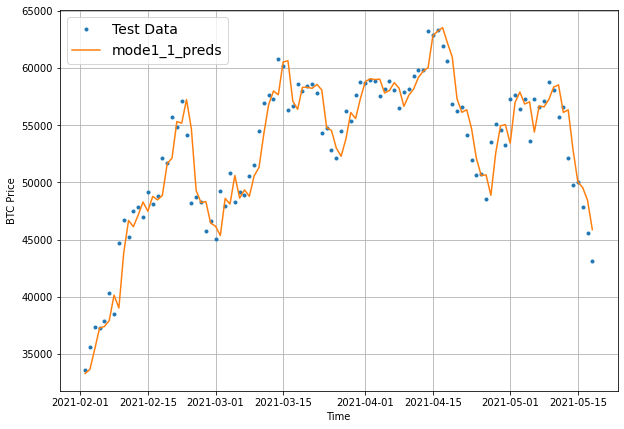

In [ ]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize = (10,7))
# Account for the test_window offset and index into test_labels to ensrue correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start = offset, 
                 label = "Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_1_preds, 
                 start = offset,
                 format = "-", 
                 label = "mode1_1_preds")

We are getting the predictions slightly after the test data values search "autoregression"

## Model 2: Dense model (window = 30, horizon = 1)

In [ ]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 30 # use the past 30 days of Bitcoin data to make the prediction

Use our make windows function we created

In [ ]:
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

Window indexes:
 (array([[   0,    1,    2, ...,   28,   29,   30],
       [   1,    2,    3, ...,   29,   30,   31],
       [   2,    3,    4, ...,   30,   31,   32],
       ...,
       [2754, 2755, 2756, ..., 2782, 2783, 2784],
       [2755, 2756, 2757, ..., 2783, 2784, 2785],
       [2756, 2757, 2758, ..., 2784, 2785, 2786]]), (2757, 31))


(2757, 2757)

Using our make_train_test_splits function to create our train and test windows and labels

In [ ]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, 
                                                                                full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)


# 1. Construct model

model_2 = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON, activation = "linear") # linear activation is the same as having no activation
], name = "model_2_dense") # name our model so we can save it

# 2. Compile
model_2.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae", "mse"])

# 3. Fit the model
model_2.fit(x = train_windows,
            y = train_labels,
            epochs = 100,
            verbose = 0,
            batch_size = 128, # datasets are smaller 
            validation_data = (test_windows, test_labels),
            callbacks =[create_model_checkpoint(model_name = model_2.name)])

In [ ]:
# Evaluate model on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 659.3332 - mae: 659.3332 - mse: 1397247.7500


[659.3331909179688, 659.3331909179688, 1397247.75]

In [ ]:
# Load in saved best performing model_1 and evaluate it on test dataset
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 605.8741 - mae: 605.8741 - mse: 1273360.7500


[605.8740844726562, 605.8740844726562, 1273360.75]

Making forecasts on our model Using our makepreds function

In [ ]:
# Make predictions using model_2 on the test dataset and view results # with our makepreds() function
model_2_preds = make_preds(model_2, test_windows)
len(model_2_preds), model_2_preds[:10]

18/18 [==============================] - 0s 1ms/step


(552, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8882.84  , 8904.423 , 8762.442 , 8559.087 , 8428.983 , 8327.641 ,
        8256.728 , 8126.8335, 8171.7334, 7796.058 ], dtype=float32)>)

In [ ]:
test_labels[:10]

array([[8749.52059102],
       [8656.97092235],
       [8500.64355816],
       [8469.2608989 ],
       [8537.33965197],
       [8205.80636599],
       [8118.4885358 ],
       [8074.84317361],
       [7612.7405735 ],
       [7262.11053495]])

In [ ]:
tf.squeeze(test_labels).shape, model_2_preds.shape

(TensorShape([552]), TensorShape([552]))

In [ ]:
# Evaluate preds
model_2_results= evaluate_preds(y_true = tf.squeeze(test_labels),
                                y_pred = model_2_preds)
model_2_results

{'mae': 605.8741,
 'mse': 1273360.8,
 'rmse': 1128.4329,
 'mape': 2.726445,
 'mase': 1.0590738}

In [ ]:
naive_results # in any open market the naive model is quite hard to beat

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [ ]:
model_1_results

{'mae': 568.95105,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

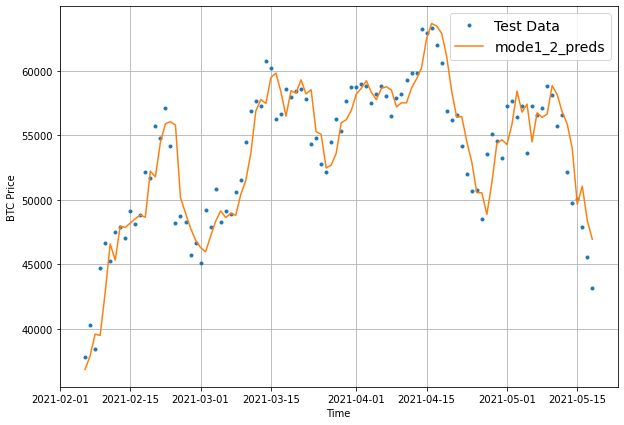

In [ ]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize = (10,7))
# Account for the test_window offset and index into test_labels to ensrue correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start = offset, 
                 label = "Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_2_preds, 
                 start = offset,
                 format = "-", 
                 label = "mode1_2_preds")

Slightly worse because the MAE is higher
Model 2 performed worse when window size increased from 7 to 30

## Model 3: Dense model (window = 30, horizon = 7)

In [ ]:
# Let's setup global variables for window and horizon size
HORIZON = 7 # predict next 1 day
WINDOW_SIZE = 30 # use the past week of Bitcoin data to make the prediction

Using our make windows function

In [ ]:
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

Window indexes:
 (array([[   0,    1,    2, ...,   34,   35,   36],
       [   1,    2,    3, ...,   35,   36,   37],
       [   2,    3,    4, ...,   36,   37,   38],
       ...,
       [2748, 2749, 2750, ..., 2782, 2783, 2784],
       [2749, 2750, 2751, ..., 2783, 2784, 2785],
       [2750, 2751, 2752, ..., 2784, 2785, 2786]]), (2751, 37))


(2751, 2751)

Using our make_train_test_splits function

In [ ]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)


# 1. Construct model

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON, activation = "linear") # linear activation is the same as having no activation
], name = "model_3_dense") # name our model so we can save it

# 2. Compile
model_3.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae", "mse"])

# 3. Fit the model
model_3.fit(x = train_windows,
            y = train_labels,
            epochs = 100,
            verbose = 1,
            batch_size = 128, # datasets are smaller 
            validation_data = (test_windows, test_labels),
            callbacks =[create_model_checkpoint(model_name = model_3.name)])

Epoch 1/100
18/18 [==============================] - 1s 36ms/step - loss: 1476.6752 - mae: 1476.6752 - mse: 10390733.0000 - val_loss: 3088.5613 - val_mae: 3088.5613 - val_mse: 24386346.0000
Epoch 2/100
18/18 [==============================] - 0s 27ms/step - loss: 552.8943 - mae: 552.8943 - mse: 1336176.8750 - val_loss: 2462.4548 - val_mae: 2462.4548 - val_mse: 17112268.0000
Epoch 3/100
18/18 [==============================] - 0s 28ms/step - loss: 435.1978 - mae: 435.1978 - mse: 893449.0000 - val_loss: 2283.1484 - val_mae: 2283.1484 - val_mse: 14950889.0000
Epoch 4/100
18/18 [==============================] - 0s 28ms/step - loss: 391.9787 - mae: 391.9787 - mse: 745983.8125 - val_loss: 1975.1218 - val_mae: 1975.1218 - val_mse: 11680637.0000
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 357.9485 - mae: 357.9485 - mse: 627137.9375 - val_loss: 2000.1556 - val_mae: 2000.1556 - val_mse: 11665231.0000
Epoch 6/100
18/18 [==============================] - 0s 27ms/step 

In [ ]:
# Evaluate model on test data
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1300.1523 - mae: 1300.1523 - mse: 5599957.0000


[1300.15234375, 1300.15234375, 5599957.0]

In [ ]:
# Load in saved best performing model_3 and evaluate it on test dataset
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1237.5065 - mae: 1237.5065 - mse: 5405199.0000


[1237.5064697265625, 1237.5064697265625, 5405199.0]

Using our makepreds function

In [ ]:
# Make predictions using model_3 on the test dataset and view results # with our makepreds() function
model_3_preds = make_preds(model_3, test_windows)
len(model_3_preds), model_3_preds[:5]

18/18 [==============================] - 0s 1ms/step


(551, <tf.Tensor: shape=(5, 7), dtype=float32, numpy=
 array([[9004.694 , 9048.1   , 9425.09  , 9258.256 , 9495.797 , 9558.453 ,
         9357.3545],
        [8735.506 , 8840.303 , 9247.793 , 8885.601 , 9097.186 , 9174.327 ,
         9156.818 ],
        [8672.508 , 8782.387 , 9123.857 , 8770.371 , 9007.13  , 9003.869 ,
         9042.725 ],
        [8874.399 , 8784.74  , 9043.902 , 8943.052 , 9033.477 , 9176.489 ,
         9039.677 ],
        [8825.891 , 8777.44  , 8926.78  , 8870.179 , 9213.232 , 9268.156 ,
         8942.487 ]], dtype=float32)>)

In [ ]:
model_2_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8882.84 , 8904.423, 8762.442, 8559.087, 8428.983], dtype=float32)>

In [ ]:
test_labels[:10]

array([[8794.35864452, 8798.04205463, 9081.18687849, 8711.53433917,
        8760.89271814, 8749.52059102, 8656.97092235],
       [8798.04205463, 9081.18687849, 8711.53433917, 8760.89271814,
        8749.52059102, 8656.97092235, 8500.64355816],
       [9081.18687849, 8711.53433917, 8760.89271814, 8749.52059102,
        8656.97092235, 8500.64355816, 8469.2608989 ],
       [8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 , 8537.33965197],
       [8760.89271814, 8749.52059102, 8656.97092235, 8500.64355816,
        8469.2608989 , 8537.33965197, 8205.80636599],
       [8749.52059102, 8656.97092235, 8500.64355816, 8469.2608989 ,
        8537.33965197, 8205.80636599, 8118.4885358 ],
       [8656.97092235, 8500.64355816, 8469.2608989 , 8537.33965197,
        8205.80636599, 8118.4885358 , 8074.84317361],
       [8500.64355816, 8469.2608989 , 8537.33965197, 8205.80636599,
        8118.4885358 , 8074.84317361, 7612.7405735 ],
       [8469.2608989 , 8

In [ ]:
tf.squeeze(test_labels).shape, model_3_preds.shape

(TensorShape([551, 7]), TensorShape([551, 7]))

In [ ]:
model_3_preds.shape, model_2_preds.shape

(TensorShape([551, 7]), TensorShape([552]))

In [ ]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1237.5065 - mae: 1237.5065 - mse: 5405199.0000


[1237.5064697265625, 1237.5064697265625, 5405199.0]

In [ ]:
model_2_results["mae"].ndim

0

In [ ]:
# Create a function to take in model r predictions and truth values and return evaluation metrics

def evaluate_preds(y_true, y_pred):
  # Make sure float 32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype = tf.float32) # This is how it's done
  y_pred = tf.cast(y_pred, dtype = tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)
    
  return {"mae" : mae.numpy(),
          "mse" : mse.numpy(),
          "rmse" : rmse.numpy(),
          "mape" : mape.numpy(),
          "mase" : mase.numpy()}

In [ ]:
# Evaluate model_3 results
model_3_results= evaluate_preds(y_true = tf.squeeze(test_labels),
                                y_pred = model_3_preds)
model_3_results

{'mae': 1237.5065,
 'mse': 5405199.0,
 'rmse': 1425.7478,
 'mape': 5.558879,
 'mase': 2.2020733}

In [ ]:
model_1_results, model_2_results, naive_results # in any open market the naive model is quite hard to beat

({'mae': 568.95105,
  'mse': 1171743.8,
  'rmse': 1082.4711,
  'mape': 2.5448983,
  'mase': 0.9994894},
 {'mae': 605.8741,
  'mse': 1273360.8,
  'rmse': 1128.4329,
  'mape': 2.726445,
  'mase': 1.0590738},
 {'mae': 567.9802,
  'mse': 1147547.0,
  'rmse': 1071.2362,
  'mape': 2.516525,
  'mase': 0.99957})

In [ ]:
test_labels.shape

(551, 7)

We've made and evaluated predictions with `model_3`, let's visualize, visualize, visualize!

In [ ]:
X_test[-len(test_windows):] # this gives us the dates - from the dataframe we originally created from our imported bitcoin data

array(['2019-11-15T00:00:00.000000000', '2019-11-16T00:00:00.000000000',
       '2019-11-17T00:00:00.000000000', '2019-11-18T00:00:00.000000000',
       '2019-11-19T00:00:00.000000000', '2019-11-20T00:00:00.000000000',
       '2019-11-21T00:00:00.000000000', '2019-11-22T00:00:00.000000000',
       '2019-11-23T00:00:00.000000000', '2019-11-24T00:00:00.000000000',
       '2019-11-25T00:00:00.000000000', '2019-11-26T00:00:00.000000000',
       '2019-11-27T00:00:00.000000000', '2019-11-28T00:00:00.000000000',
       '2019-11-29T00:00:00.000000000', '2019-11-30T00:00:00.000000000',
       '2019-12-01T00:00:00.000000000', '2019-12-02T00:00:00.000000000',
       '2019-12-03T00:00:00.000000000', '2019-12-04T00:00:00.000000000',
       '2019-12-05T00:00:00.000000000', '2019-12-06T00:00:00.000000000',
       '2019-12-07T00:00:00.000000000', '2019-12-08T00:00:00.000000000',
       '2019-12-09T00:00:00.000000000', '2019-12-10T00:00:00.000000000',
       '2019-12-11T00:00:00.000000000', '2019-12-12

In [ ]:
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9004.694 , 9048.1   , 9425.09  , 9258.256 , 9495.797 , 9558.453 ,
        9357.3545],
       [8735.506 , 8840.303 , 9247.793 , 8885.601 , 9097.186 , 9174.327 ,
        9156.818 ],
       [8672.508 , 8782.387 , 9123.857 , 8770.371 , 9007.13  , 9003.869 ,
        9042.725 ],
       [8874.399 , 8784.74  , 9043.902 , 8943.052 , 9033.477 , 9176.489 ,
        9039.677 ],
       [8825.891 , 8777.44  , 8926.78  , 8870.179 , 9213.232 , 9268.156 ,
        8942.487 ]], dtype=float32)>

In [ ]:
test_labels[:, 0] # every single row, but gets the first value

array([ 8794.35864452,  8798.04205463,  9081.18687849,  8711.53433917,
        8760.89271814,  8749.52059102,  8656.97092235,  8500.64355816,
        8469.2608989 ,  8537.33965197,  8205.80636599,  8118.4885358 ,
        8074.84317361,  7612.7405735 ,  7262.11053495,  7303.40575852,
        7041.73293642,  7211.86180875,  7141.06944869,  7523.4806726 ,
        7390.20746923,  7729.26593894,  7542.23560864,  7381.96300782,
        7333.43293049,  7315.36776456,  7213.73376172,  7398.78704961,
        7511.88058312,  7532.12351309,  7550.23919987,  7333.09604316,
        7239.76257544,  7198.06667705,  7190.27236926,  7238.87432299,
        7087.02498535,  7112.73147612,  6883.49639377,  6584.02884335,
        7424.01540023,  7147.56832379,  7139.93337053,  7286.33508116,
        7236.98620461,  7166.17237853,  7235.6266505 ,  7212.80939522,
        7183.70653603,  7227.29371168,  7311.56064392,  7385.46484791,
        7251.27679432,  7179.95781929,  7174.74401195,  6955.48757967,
      

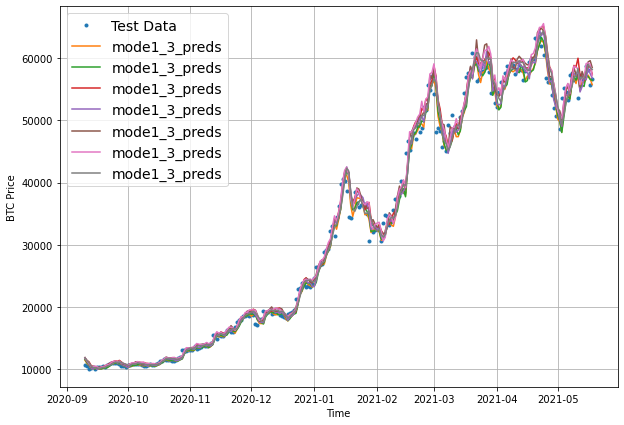

In [ ]:
# Let's plot our model 1 predictions
offset = 300
plt.figure(figsize = (10,7))
# Account for the test_window offset and index into test_labels to ensrue correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start = offset, 
                 label = "Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_3_preds, 
                 start = offset,
                 format = "-", 
                 label = "mode1_3_preds")

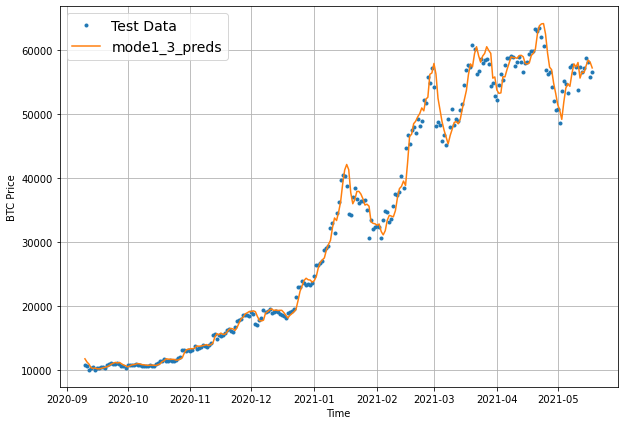

In [ ]:
offset = 300
plt.figure(figsize = (10,7))

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start = offset, 
                 label = "Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis = 1), # changing our 7 day forecast into a single value (reduced to the mean of the horizon window) - though not a true representation of our data
                 start = offset,
                 format = "-", 
                 label = "mode1_3_preds")

In [ ]:
model_3_preds[0]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([9004.694 , 9048.1   , 9425.09  , 9258.256 , 9495.797 , 9558.453 ,
       9357.3545], dtype=float32)>

In [ ]:
tf.reduce_mean(model_3_preds[0])

<tf.Tensor: shape=(), dtype=float32, numpy=9306.821>

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [ ]:
model_1_results

{'mae': 568.95105,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

In [ ]:
model_2_results

{'mae': 605.8741,
 'mse': 1273360.8,
 'rmse': 1128.4329,
 'mape': 2.726445,
 'mase': 1.0590738}

In [ ]:
model_3_results

{'mae': 1237.5065,
 'mse': 5405199.0,
 'rmse': 1425.7478,
 'mape': 5.558879,
 'mase': 2.2020733}

## Which of our models is performing the best so far?
So we've trained a few models, now let's compare them and see how they've gone...

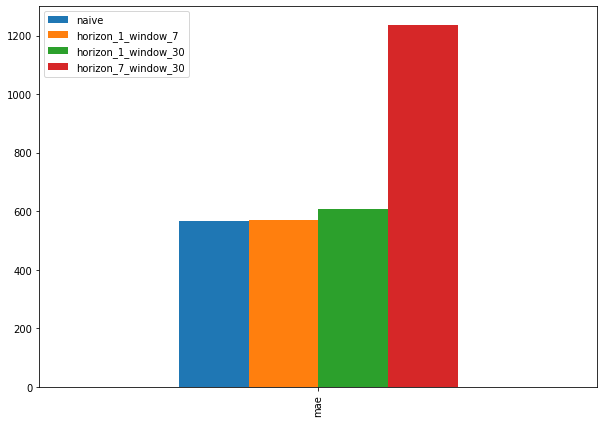

In [ ]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index =["mae"]).plot(figsize = (10,7), kind = "bar")

Check this reading https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

## Model 4: Conv1D

In [ ]:
HORIZON = 1 # predict next day of bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data


In [ ]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

Window indexes:
 (array([[   0,    1,    2, ...,    5,    6,    7],
       [   1,    2,    3, ...,    6,    7,    8],
       [   2,    3,    4, ...,    7,    8,    9],
       ...,
       [2777, 2778, 2779, ..., 2782, 2783, 2784],
       [2778, 2779, 2780, ..., 2783, 2784, 2785],
       [2779, 2780, 2781, ..., 2784, 2785, 2786]]), (2780, 8))


(2780, 2780)

In [ ]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)


(2224, 2224, 556, 556)

We need an input shape of : `(batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet...

In [ ]:
# Check data input shape
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis = 1)) # add an extra dimension for `input_dim`

In [ ]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # output = 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [ ]:
x.numpy()

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])

Lambda allows the expansion dimension expression to be passed as a layer through our model

## Model 4: Conv1D model (window = 7, horizon = 1)

In [ ]:
tf.random.set_seed(42)

# Create Conv1D model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis = 1)), # 'x' can be replaced by anything
    layers.Conv1D(filters = 128, 
                  kernel_size = 5,
                  strides = 1,
                  padding = "causal",
                  activation = "relu"),
    layers.Dense(HORIZON)
], name = "model_4_conv1D")

# Compile the model
model_4.compile(loss = "mae",
                optimizer = tf.keras.optimizers.Adam())

# Fit the model
model_4.fit(train_windows,
            train_labels,
            batch_size = 128,
            epochs = 100,
            verbose = 1,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name=model_4.name)])

# Conv1D model, filters = 128, kernel_size =, padding...
# output layer = dense

Epoch 1/100
14/18 [======================>.......] - ETA: 0s - loss: 1442.0208  

18/18 [==============================] - 7s 62ms/step - loss: 1207.3817 - val_loss: 2320.6218
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 353.1946

18/18 [==============================] - 1s 37ms/step - loss: 316.2171 - val_loss: 1467.2799
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 192.6853

18/18 [==============================] - 1s 52ms/step - loss: 192.6853 - val_loss: 1164.7074
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 228.4294

18/18 [==============================] - 1s 37ms/step - loss: 177.3535 - val_loss: 981.6695
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 169.5955

18/18 [==============================] - 1s 37ms/step - loss: 172.3467 - val_loss: 960.8708
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 130.1246

18/18 [==============================] - 1s 38ms/step - loss: 171.9753 - val_loss: 950.2026
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 209.6378

18/18 [==============================] - 1s 37ms/step - loss: 167.1943 - val_loss: 943.2872
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 143.1056

18/18 [==============================] - 1s 38ms/step - loss: 163.5990 - val_loss: 905.5262
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 162.5455 - val_loss: 929.7607
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 176.2612

18/18 [==============================] - 1s 36ms/step - loss: 158.5780 - val_loss: 871.9778
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 172.6847

18/18 [==============================] - 1s 37ms/step - loss: 154.0058 - val_loss: 852.7120
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 151.2620 - val_loss: 944.1970
Epoch 13/100
18/18 [==============================] - 0s 5ms/step - loss: 150.2688 - val_loss: 881.1826
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 157.3245

18/18 [==============================] - 1s 36ms/step - loss: 145.4593 - val_loss: 849.1818
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 143.7761

18/18 [==============================] - 1s 38ms/step - loss: 143.3640 - val_loss: 844.4007
Epoch 16/100
18/18 [==============================] - ETA: 0s - loss: 139.8764

18/18 [==============================] - 1s 38ms/step - loss: 139.8764 - val_loss: 806.7261
Epoch 17/100
18/18 [==============================] - 0s 4ms/step - loss: 138.1677 - val_loss: 812.6340
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 147.8408

18/18 [==============================] - 1s 51ms/step - loss: 137.9497 - val_loss: 775.2100
Epoch 19/100
18/18 [==============================] - ETA: 0s - loss: 131.1450

18/18 [==============================] - 1s 39ms/step - loss: 131.1450 - val_loss: 755.4260
Epoch 20/100
16/18 [=========================>....] - ETA: 0s - loss: 130.9040

18/18 [==============================] - 1s 37ms/step - loss: 132.4057 - val_loss: 712.2014
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 162.8896

18/18 [==============================] - 1s 37ms/step - loss: 131.0829 - val_loss: 707.4122
Epoch 22/100
18/18 [==============================] - ETA: 0s - loss: 126.9511

18/18 [==============================] - 1s 72ms/step - loss: 126.9511 - val_loss: 692.9736
Epoch 23/100
11/18 [=================>............] - ETA: 0s - loss: 122.0763

18/18 [==============================] - 1s 64ms/step - loss: 125.1489 - val_loss: 682.4753
Epoch 24/100
18/18 [==============================] - ETA: 0s - loss: 124.3786

18/18 [==============================] - 1s 79ms/step - loss: 124.3786 - val_loss: 670.8320
Epoch 25/100
14/18 [======================>.......] - ETA: 0s - loss: 124.1603

18/18 [==============================] - 2s 96ms/step - loss: 121.6896 - val_loss: 662.6083
Epoch 26/100
16/18 [=========================>....] - ETA: 0s - loss: 123.1287

18/18 [==============================] - 2s 98ms/step - loss: 121.5705 - val_loss: 654.6090
Epoch 27/100
17/18 [===========================>..] - ETA: 0s - loss: 122.2792

18/18 [==============================] - 1s 47ms/step - loss: 122.6445 - val_loss: 650.9058
Epoch 28/100
13/18 [====================>.........] - ETA: 0s - loss: 117.9929

18/18 [==============================] - 1s 39ms/step - loss: 117.9562 - val_loss: 645.4808
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 112.9740

18/18 [==============================] - 1s 37ms/step - loss: 117.1769 - val_loss: 639.9748
Epoch 30/100
18/18 [==============================] - ETA: 0s - loss: 121.0468

18/18 [==============================] - 1s 52ms/step - loss: 121.0468 - val_loss: 630.7950
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 114.9061 - val_loss: 652.6464
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 113.9315

18/18 [==============================] - 1s 37ms/step - loss: 116.4313 - val_loss: 623.4980
Epoch 33/100
18/18 [==============================] - 0s 4ms/step - loss: 115.7972 - val_loss: 664.3209
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 142.3728

18/18 [==============================] - 1s 39ms/step - loss: 117.2043 - val_loss: 613.7654
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 113.4074 - val_loss: 619.6227
Epoch 36/100
18/18 [==============================] - ETA: 0s - loss: 116.8330

18/18 [==============================] - 1s 38ms/step - loss: 116.8330 - val_loss: 605.7616
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 134.0515

18/18 [==============================] - 1s 38ms/step - loss: 114.7925 - val_loss: 603.6094
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 102.6344

18/18 [==============================] - 1s 38ms/step - loss: 113.0861 - val_loss: 602.5891
Epoch 39/100
12/18 [===================>..........] - ETA: 0s - loss: 114.7775

18/18 [==============================] - 1s 58ms/step - loss: 111.9831 - val_loss: 602.2945
Epoch 40/100
18/18 [==============================] - ETA: 0s - loss: 111.2691

18/18 [==============================] - 1s 37ms/step - loss: 111.2691 - val_loss: 600.5515
Epoch 41/100
18/18 [==============================] - 0s 4ms/step - loss: 112.0727 - val_loss: 623.0615
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 116.7095 - val_loss: 645.0155
Epoch 43/100
18/18 [==============================] - 0s 4ms/step - loss: 118.9676 - val_loss: 659.5667
Epoch 44/100
18/18 [==============================] - 0s 4ms/step - loss: 125.4497 - val_loss: 678.8228
Epoch 45/100
18/18 [==============================] - 0s 4ms/step - loss: 115.4361 - val_loss: 611.8370
Epoch 46/100
18/18 [==============================] - ETA: 0s - loss: 114.1717

18/18 [==============================] - 1s 52ms/step - loss: 114.1717 - val_loss: 589.6738
Epoch 47/100
18/18 [==============================] - 0s 8ms/step - loss: 113.7248 - val_loss: 720.2481
Epoch 48/100
18/18 [==============================] - 0s 8ms/step - loss: 112.0136 - val_loss: 597.4332
Epoch 49/100
18/18 [==============================] - 0s 10ms/step - loss: 110.5680 - val_loss: 665.2030
Epoch 50/100
18/18 [==============================] - 0s 11ms/step - loss: 119.7653 - val_loss: 635.1696
Epoch 51/100
 9/18 [==============>...............] - ETA: 0s - loss: 107.3582

18/18 [==============================] - 1s 80ms/step - loss: 110.7739 - val_loss: 586.0245
Epoch 52/100
18/18 [==============================] - 0s 8ms/step - loss: 111.2179 - val_loss: 595.2483
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 113.6466 - val_loss: 670.5778
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 126.7883 - val_loss: 648.2971
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 110.6968 - val_loss: 593.8555
Epoch 56/100
18/18 [==============================] - 0s 4ms/step - loss: 109.8592 - val_loss: 766.5007
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 124.8183 - val_loss: 712.2674
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 120.3515 - val_loss: 698.5149
Epoch 59/100
18/18 [==============================] - 0s 4ms/step - loss: 110.8185 - val_loss: 592.1150
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 11

18/18 [==============================] - 1s 55ms/step - loss: 108.1684 - val_loss: 577.6281
Epoch 63/100
18/18 [==============================] - 0s 7ms/step - loss: 108.7932 - val_loss: 610.1495
Epoch 64/100
18/18 [==============================] - 0s 7ms/step - loss: 110.4675 - val_loss: 652.9427
Epoch 65/100
18/18 [==============================] - 0s 9ms/step - loss: 110.7312 - val_loss: 583.0664
Epoch 66/100
18/18 [==============================] - 0s 8ms/step - loss: 108.3487 - val_loss: 587.8362
Epoch 67/100
18/18 [==============================] - 0s 9ms/step - loss: 108.0646 - val_loss: 648.5150
Epoch 68/100
18/18 [==============================] - 0s 8ms/step - loss: 113.6957 - val_loss: 675.1595
Epoch 69/100
18/18 [==============================] - 0s 9ms/step - loss: 124.3082 - val_loss: 632.9845
Epoch 70/100
18/18 [==============================] - 0s 7ms/step - loss: 124.3231 - val_loss: 588.5080
Epoch 71/100
18/18 [==============================] - 0s 9ms/step - loss: 11

18/18 [==============================] - 1s 37ms/step - loss: 106.6291 - val_loss: 575.4403
Epoch 82/100
 1/18 [>.............................] - ETA: 0s - loss: 192.2652

18/18 [==============================] - 1s 53ms/step - loss: 114.2934 - val_loss: 571.6199
Epoch 83/100
18/18 [==============================] - 0s 4ms/step - loss: 111.1759 - val_loss: 666.0590
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 112.2543 - val_loss: 580.0314
Epoch 85/100
18/18 [==============================] - 0s 4ms/step - loss: 107.7741 - val_loss: 599.6221
Epoch 86/100
18/18 [==============================] - 0s 4ms/step - loss: 108.7533 - val_loss: 599.0880
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 106.9682 - val_loss: 596.5336
Epoch 88/100
18/18 [==============================] - 0s 4ms/step - loss: 107.9607 - val_loss: 598.1052
Epoch 89/100
 1/18 [>.............................] - ETA: 0s - loss: 106.7720

18/18 [==============================] - 1s 38ms/step - loss: 107.3045 - val_loss: 570.8284
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 108.0094 - val_loss: 642.3939
Epoch 91/100
18/18 [==============================] - 0s 4ms/step - loss: 113.7574 - val_loss: 625.3716
Epoch 92/100
18/18 [==============================] - 0s 4ms/step - loss: 108.0017 - val_loss: 627.3054
Epoch 93/100
18/18 [==============================] - 0s 4ms/step - loss: 118.0999 - val_loss: 637.1274
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 111.3195 - val_loss: 579.6985
Epoch 95/100
18/18 [==============================] - 0s 6ms/step - loss: 106.8561 - val_loss: 572.8486
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 115.0598 - val_loss: 602.3210
Epoch 97/100
18/18 [==============================] - 0s 4ms/step - loss: 109.4901 - val_loss: 616.3585
Epoch 98/100
18/18 [==============================] - 0s 4ms/step - loss: 11

In [ ]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               3968      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


Comparing the summaries of model_4 and model_2, the output shape for model_4 is different to model_2

In [ ]:
# Evaluate model...
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 610.1541


610.154052734375

In [ ]:
# Load back in best performing Conv1D and reevaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

# improvefd our evaluation by 40 points

18/18 [==============================] - 0s 3ms/step - loss: 570.8284


570.828369140625

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8851.464, 8754.47 , 8983.927, 8759.671, 8703.627, 8708.294,
       8661.667, 8494.839, 8435.316, 8492.114], dtype=float32)>

In [ ]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_4_preds)
model_4_results

{'mae': 570.82837,
 'mse': 1176671.2,
 'rmse': 1084.7448,
 'mape': 2.5593357,
 'mase': 1.0027874}

In [ ]:
model_1_results


{'mae': 568.95105,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

In [ ]:
# Exercise try to improve model_4

## Model 5: RNN (LSTM) model

In [ ]:
tf.random.set_seed(42)

# Create LSTM model with the functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis = 1))(inputs)
x = layers.LSTM(128, return_sequences = True, activation = "relu")(x)
#x = layers.LSTM(128)(x)
x = layers.Conv1D(filters = 128, 
                  kernel_size = 5,
                  strides = 1,
                  padding = "causal",
                  activation = "relu")(x)

outputs = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs = inputs, outputs = outputs, name = "model_5_LSTM")
# Compile the model
model_5.compile(loss = "mae",
                optimizer = tf.keras.optimizers.Adam())

# Fit the model
model_5.fit(train_windows,
            train_labels,
            batch_size = 128,
            epochs = 100,
            verbose = 1,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name=model_5.name)])

# Conv1D model, filters = 128, kernel_size =, padding...
# output layer = dense

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 2481.1755

18/18 [==============================] - 4s 138ms/step - loss: 2481.1755 - val_loss: 8725.1250
Epoch 2/100
10/18 [===============>..............] - ETA: 0s - loss: 620.8032 

18/18 [==============================] - 2s 120ms/step - loss: 531.1390 - val_loss: 1098.1605
Epoch 3/100
10/18 [===============>..............] - ETA: 0s - loss: 239.4748

18/18 [==============================] - 2s 135ms/step - loss: 224.6315 - val_loss: 1035.1785
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 176.3815 - val_loss: 1045.2183
Epoch 5/100
 9/18 [==============>...............] - ETA: 0s - loss: 186.3957

18/18 [==============================] - 2s 115ms/step - loss: 173.0980 - val_loss: 942.3593
Epoch 6/100
18/18 [==============================] - ETA: 0s - loss: 172.2123

18/18 [==============================] - 2s 116ms/step - loss: 172.2123 - val_loss: 930.6082
Epoch 7/100
10/18 [===============>..............] - ETA: 0s - loss: 179.6144

18/18 [==============================] - 2s 115ms/step - loss: 164.9365 - val_loss: 906.7193
Epoch 8/100
 9/18 [==============>...............] - ETA: 0s - loss: 155.9244

18/18 [==============================] - 2s 136ms/step - loss: 161.4270 - val_loss: 882.5955
Epoch 9/100
 9/18 [==============>...............] - ETA: 0s - loss: 159.1463

18/18 [==============================] - 2s 118ms/step - loss: 160.6473 - val_loss: 875.5699
Epoch 10/100
11/18 [=================>............] - ETA: 0s - loss: 151.5620

18/18 [==============================] - 2s 146ms/step - loss: 155.6034 - val_loss: 836.3570
Epoch 11/100
10/18 [===============>..............] - ETA: 0s - loss: 148.2151

18/18 [==============================] - 2s 117ms/step - loss: 147.3540 - val_loss: 819.8103
Epoch 12/100
16/18 [=========================>....] - ETA: 0s - loss: 141.6397

18/18 [==============================] - 3s 163ms/step - loss: 141.5713 - val_loss: 778.3615
Epoch 13/100
18/18 [==============================] - 0s 14ms/step - loss: 148.3862 - val_loss: 862.0865
Epoch 14/100
18/18 [==============================] - 0s 13ms/step - loss: 141.9590 - val_loss: 807.8163
Epoch 15/100
18/18 [==============================] - 0s 14ms/step - loss: 144.7295 - val_loss: 825.5585
Epoch 16/100
18/18 [==============================] - 0s 13ms/step - loss: 134.7257 - val_loss: 805.3570
Epoch 17/100
18/18 [==============================] - 0s 15ms/step - loss: 129.8998 - val_loss: 801.4674
Epoch 18/100
17/18 [===========================>..] - ETA: 0s - loss: 128.8134

18/18 [==============================] - 2s 119ms/step - loss: 127.8230 - val_loss: 689.6831
Epoch 19/100
18/18 [==============================] - 0s 7ms/step - loss: 125.2626 - val_loss: 741.5154
Epoch 20/100
10/18 [===============>..............] - ETA: 0s - loss: 129.5270

18/18 [==============================] - 2s 115ms/step - loss: 123.4830 - val_loss: 675.1417
Epoch 21/100
11/18 [=================>............] - ETA: 0s - loss: 129.2290

18/18 [==============================] - 2s 117ms/step - loss: 125.2165 - val_loss: 648.9545
Epoch 22/100
18/18 [==============================] - 0s 8ms/step - loss: 120.3042 - val_loss: 675.2312
Epoch 23/100
10/18 [===============>..............] - ETA: 0s - loss: 119.1298

18/18 [==============================] - 2s 138ms/step - loss: 121.7014 - val_loss: 641.5527
Epoch 24/100
10/18 [===============>..............] - ETA: 0s - loss: 117.8132

18/18 [==============================] - 2s 117ms/step - loss: 119.7419 - val_loss: 626.5782
Epoch 25/100
18/18 [==============================] - 0s 8ms/step - loss: 116.9003 - val_loss: 653.2064
Epoch 26/100
10/18 [===============>..............] - ETA: 0s - loss: 121.4350

18/18 [==============================] - 2s 118ms/step - loss: 120.6863 - val_loss: 623.0117
Epoch 27/100
10/18 [===============>..............] - ETA: 0s - loss: 121.0238

18/18 [==============================] - 2s 117ms/step - loss: 119.0099 - val_loss: 612.2509
Epoch 28/100
18/18 [==============================] - ETA: 0s - loss: 114.4501

18/18 [==============================] - 2s 139ms/step - loss: 114.4501 - val_loss: 611.1041
Epoch 29/100
18/18 [==============================] - 0s 8ms/step - loss: 114.0820 - val_loss: 616.7139
Epoch 30/100
10/18 [===============>..............] - ETA: 0s - loss: 112.7465

18/18 [==============================] - 2s 120ms/step - loss: 120.2703 - val_loss: 606.1497
Epoch 31/100
10/18 [===============>..............] - ETA: 0s - loss: 117.5285

18/18 [==============================] - 2s 115ms/step - loss: 118.3026 - val_loss: 605.4694
Epoch 32/100
18/18 [==============================] - 0s 8ms/step - loss: 114.5053 - val_loss: 682.4702
Epoch 33/100
11/18 [=================>............] - ETA: 0s - loss: 114.9605

18/18 [==============================] - 2s 116ms/step - loss: 113.6536 - val_loss: 604.5502
Epoch 34/100
18/18 [==============================] - 0s 8ms/step - loss: 113.8348 - val_loss: 610.9152
Epoch 35/100
10/18 [===============>..............] - ETA: 0s - loss: 111.9492

18/18 [==============================] - 2s 142ms/step - loss: 114.4342 - val_loss: 596.3761
Epoch 36/100
10/18 [===============>..............] - ETA: 0s - loss: 110.5975

18/18 [==============================] - 2s 118ms/step - loss: 116.2072 - val_loss: 595.1351
Epoch 37/100
18/18 [==============================] - 0s 7ms/step - loss: 111.2421 - val_loss: 598.5068
Epoch 38/100
18/18 [==============================] - 0s 8ms/step - loss: 113.3512 - val_loss: 630.5038
Epoch 39/100
11/18 [=================>............] - ETA: 0s - loss: 115.3082

18/18 [==============================] - 2s 115ms/step - loss: 114.8657 - val_loss: 592.0907
Epoch 40/100
18/18 [==============================] - 0s 7ms/step - loss: 112.2159 - val_loss: 644.1341
Epoch 41/100
10/18 [===============>..............] - ETA: 0s - loss: 118.2572

18/18 [==============================] - 2s 115ms/step - loss: 112.3621 - val_loss: 589.8763
Epoch 42/100
18/18 [==============================] - 0s 8ms/step - loss: 115.4358 - val_loss: 728.2186
Epoch 43/100
18/18 [==============================] - 0s 7ms/step - loss: 121.9901 - val_loss: 705.9094
Epoch 44/100
11/18 [=================>............] - ETA: 0s - loss: 114.6327

18/18 [==============================] - 2s 137ms/step - loss: 115.7760 - val_loss: 587.7104
Epoch 45/100
18/18 [==============================] - 0s 8ms/step - loss: 109.7107 - val_loss: 598.6735
Epoch 46/100
 9/18 [==============>...............] - ETA: 0s - loss: 116.3207

18/18 [==============================] - 2s 118ms/step - loss: 111.4819 - val_loss: 584.7370
Epoch 47/100
18/18 [==============================] - 0s 8ms/step - loss: 111.0936 - val_loss: 642.9713
Epoch 48/100
18/18 [==============================] - 0s 7ms/step - loss: 110.4233 - val_loss: 600.2665
Epoch 49/100
18/18 [==============================] - 0s 7ms/step - loss: 112.3144 - val_loss: 664.2677
Epoch 50/100
18/18 [==============================] - 0s 7ms/step - loss: 124.2706 - val_loss: 610.0450
Epoch 51/100
18/18 [==============================] - 0s 7ms/step - loss: 113.6850 - val_loss: 589.3983
Epoch 52/100
18/18 [==============================] - 0s 9ms/step - loss: 111.5769 - val_loss: 585.2501
Epoch 53/100
18/18 [==============================] - 0s 8ms/step - loss: 113.3787 - val_loss: 650.3320
Epoch 54/100
14/18 [======================>.......] - ETA: 0s - loss: 116.7782

18/18 [==============================] - 3s 193ms/step - loss: 112.3022 - val_loss: 582.2910
Epoch 55/100
18/18 [==============================] - 0s 8ms/step - loss: 116.0502 - val_loss: 645.0070
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 117.0243 - val_loss: 903.2853
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 136.7067 - val_loss: 735.3583
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 123.3266 - val_loss: 586.2241
Epoch 59/100
18/18 [==============================] - 0s 9ms/step - loss: 110.6772 - val_loss: 618.8945
Epoch 60/100
18/18 [==============================] - 0s 8ms/step - loss: 112.3816 - val_loss: 589.6695
Epoch 61/100
18/18 [==============================] - 0s 7ms/step - loss: 109.7331 - val_loss: 584.5359
Epoch 62/100
18/18 [==============================] - 0s 9ms/step - loss: 109.5648 - val_loss: 586.8404
Epoch 63/100
18/18 [==============================] - 0s 7ms/step - loss: 1

18/18 [==============================] - 3s 196ms/step - loss: 110.1732 - val_loss: 581.0352
Epoch 66/100
18/18 [==============================] - 0s 8ms/step - loss: 109.5731 - val_loss: 595.0145
Epoch 67/100
18/18 [==============================] - 0s 7ms/step - loss: 110.3210 - val_loss: 673.3391
Epoch 68/100
10/18 [===============>..............] - ETA: 0s - loss: 103.4625

18/18 [==============================] - 2s 138ms/step - loss: 111.4380 - val_loss: 578.6733
Epoch 69/100
18/18 [==============================] - 0s 7ms/step - loss: 117.1434 - val_loss: 748.0012
Epoch 70/100
18/18 [==============================] - 0s 8ms/step - loss: 125.1454 - val_loss: 609.6475
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 111.7441 - val_loss: 589.0768
Epoch 72/100
18/18 [==============================] - 0s 8ms/step - loss: 114.2263 - val_loss: 610.6957
Epoch 73/100
18/18 [==============================] - 0s 7ms/step - loss: 111.5094 - val_loss: 588.5129
Epoch 74/100
10/18 [===============>..............] - ETA: 0s - loss: 112.5419

18/18 [==============================] - 2s 120ms/step - loss: 112.0174 - val_loss: 577.5279
Epoch 75/100
18/18 [==============================] - 0s 7ms/step - loss: 111.0485 - val_loss: 587.1091
Epoch 76/100
18/18 [==============================] - 0s 7ms/step - loss: 114.1875 - val_loss: 608.9809
Epoch 77/100
10/18 [===============>..............] - ETA: 0s - loss: 111.0919

18/18 [==============================] - 2s 118ms/step - loss: 108.0065 - val_loss: 576.2715
Epoch 78/100
18/18 [==============================] - 0s 7ms/step - loss: 109.8113 - val_loss: 587.1532
Epoch 79/100
18/18 [==============================] - 0s 7ms/step - loss: 107.9376 - val_loss: 666.5280
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 115.7281 - val_loss: 665.3818
Epoch 81/100
18/18 [==============================] - 0s 9ms/step - loss: 112.8117 - val_loss: 621.5835
Epoch 82/100
18/18 [==============================] - 0s 7ms/step - loss: 120.0156 - val_loss: 610.7631
Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 119.6734 - val_loss: 687.6180
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 116.4531 - val_loss: 602.7266
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 110.9837 - val_loss: 601.8065
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 1

18/18 [==============================] - 2s 116ms/step - loss: 111.5018 - val_loss: 573.3974
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 107.7792 - val_loss: 578.8760
Epoch 90/100
18/18 [==============================] - 0s 9ms/step - loss: 109.0140 - val_loss: 579.0544
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 112.2568 - val_loss: 575.6485
Epoch 92/100
18/18 [==============================] - 0s 14ms/step - loss: 116.4830 - val_loss: 578.6382
Epoch 93/100
18/18 [==============================] - 0s 8ms/step - loss: 119.8113 - val_loss: 607.9763
Epoch 94/100
18/18 [==============================] - 0s 13ms/step - loss: 113.5466 - val_loss: 598.1649
Epoch 95/100
18/18 [==============================] - 0s 14ms/step - loss: 107.1652 - val_loss: 577.7733
Epoch 96/100
18/18 [==============================] - 0s 15ms/step - loss: 108.4873 - val_loss: 648.0765
Epoch 97/100
18/18 [==============================] - 0s 16ms/step - lo

18/18 [==============================] - 3s 198ms/step - loss: 110.5280 - val_loss: 572.8613
Epoch 100/100
18/18 [==============================] - 0s 8ms/step - loss: 117.9436 - val_loss: 656.2249


In [ ]:
model_5.summary()

Model: "model_5_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm (LSTM)                 (None, 1, 128)            69632     
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            82048     
                                                                 
 dense_7 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 151,809
Trainable params: 151,809
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Load back in best performing version of model 5 and evaluate on test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 572.8612


572.8612060546875

In [ ]:
model_5_preds = make_preds(model_5, test_windows)
model_5_preds

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 8875.231 ,  8749.666 ,  9011.883 ,  8813.708 ,  8721.12  ,
        8732.228 ,  8705.668 ,  8495.588 ,  8467.637 ,  8516.835 ,
        8271.299 ,  8106.836 ,  8054.6787,  7704.117 ,  7273.504 ,
        7245.9946,  7090.323 ,  7155.5986,  7143.014 ,  7482.0635,
        7423.577 ,  7701.34  ,  7576.434 ,  7443.3   ,  7291.21  ,
        7332.671 ,  7218.818 ,  7355.8335,  7504.8433,  7556.078 ,
        7546.389 ,  7382.9893,  7241.843 ,  7183.447 ,  7192.6465,
        7221.1846,  7120.3027,  7100.1953,  6916.5557,  6629.186 ,
        7228.818 ,  7263.8784,  7172.58  ,  7202.091 ,  7318.143 ,
        7155.732 ,  7215.625 ,  7229.543 ,  7190.5684,  7212.4194,
        7306.376 ,  7383.16  ,  7285.853 ,  7187.164 ,  7163.4375,
        6997.8496,  7209.6475,  7345.525 ,  7382.62  ,  7632.0444,
        8036.291 ,  8111.903 ,  7865.305 ,  8026.281 ,  8098.2   ,
        8161.134 ,  8106.2505,  8650.261 ,  8869.676 ,  8791.035 ,
        8859.6

In [ ]:
# Evaluate preds of our best model
model_5_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_5_preds)
model_5_results

{'mae': 572.8612,
 'mse': 1177477.2,
 'rmse': 1085.1162,
 'mape': 2.5809658,
 'mase': 1.0063585}

In [ ]:
model_1_results

{'mae': 568.95105,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

### Model 5's results narrowly misses out on both naive_forecast and model_1_results

One small tweak to a model's parameters can drastically improve it's performance

**Note:** Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

## Model 6 Multivariate model

## Make a Multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not someone tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use?

How about the bitcoin halving events?

https://www.cmcmarkets.com/en-ie/learn-cryptocurrencies/bitcoin-halving



In [ ]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Let's add the bitcoin halving events to our datasets
block_reward_1 = 50 # 3 January 2009 - this block reward isn;t in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [ ]:
block_reward_2_datetime # in the same fashion as our "bitcoin_prices" date index

numpy.datetime64('2012-11-28')

In [ ]:
# Create date ranges of where specific block_reqward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [ ]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy() # copying the bitcoin prices dataframe
bitcoin_prices_block["block_reward"] = None # set as dummy column

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2 # "-1" to locate data to last column
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3 # "-1" to locate data to last column
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [ ]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [ ]:
bitcoin_prices_block.iloc[1500:1510]


,Price,block_reward
Date,,
2017-11-09,7342.82375,12.5
2017-11-10,7250.77000,12.5
2017-11-11,6773.69500,12.5
2017-11-12,6075.30125,12.5
2017-11-13,5969.13000,12.5
2017-11-14,6666.27125,12.5
2017-11-15,6867.42625,12.5
2017-11-16,7259.30000,12.5
2017-11-17,7924.18250,12.5


In [ ]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


In [ ]:
#bitcoin_prices_block.plot(figsize=(10,7));
# This gives us a univeriate graph, we need to plot price over time vs block reward

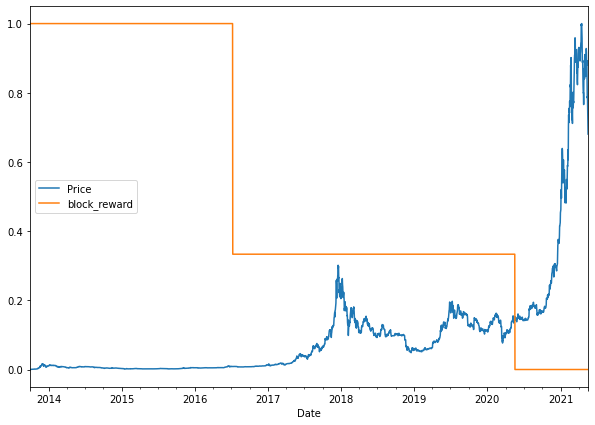

In [ ]:
# Plot the block reward vs price over time

from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns = bitcoin_prices_block.columns,
                                     index = bitcoin_prices_block.index) # gets both on the graph from 0 to 1
scaled_price_block_df.plot(figsize=(10,7));



## Making a windowed dataset with pandas

Previously, we've turned our univariate time series into a windowed dataset using the helper functions above. e.g. "make_windows"

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html



In [ ]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windoed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price +{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price +1,Price +2,Price +3,Price +4,Price +5,Price +6,Price +7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0,1,2,3,4,5,6,block_reward] -> [7]
[1,2,3,4,5,6,7,block_reward] -> [8]
[2,3,4,5,6,7,8,block_reward] -> [9]
```

In [ ]:
# Create x (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis = 1).astype(np.float32) # drops rows with NaN's values at the (start). We are also propping the "Price" column, because that will be our horizon. Then convert to "float32"
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price +1,Price +2,Price +3,Price +4,Price +5,Price +6,Price +7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

### Creating our train and test sets (and try to avoid data leakage using "indexing")

In [ ]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:] 
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
X_train, y_train, X_test, y_test

(            block_reward     Price +1     Price +2     Price +3     Price +4  \
 Date                                                                           
 2013-10-08          25.0   121.794998   120.655327   121.338661   118.674660   
 2013-10-09          25.0   123.032997   121.794998   120.655327   121.338661   
 2013-10-10          25.0   124.049004   123.032997   121.794998   120.655327   
 2013-10-11          25.0   125.961159   124.049004   123.032997   121.794998   
 2013-10-12          25.0   125.279663   125.961159   124.049004   123.032997   
 ...                  ...          ...          ...          ...          ...   
 2019-11-05          12.5  9202.415039  9290.896484  9197.632812  9131.410156   
 2019-11-06          12.5  9369.627930  9202.415039  9290.896484  9197.632812   
 2019-11-07          12.5  9326.599609  9369.627930  9202.415039  9290.896484   
 2019-11-08          12.5  9335.751953  9326.599609  9369.627930  9202.415039   
 2019-11-09          12.5  9

In [ ]:
# Create our model (same as model_1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed
tf.random.set_seed(42)

# 1. Create model 6

model_6 = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON, activation = "linear") # linear activation is the same as having no activation
], name = "model_6_multivariate")

# 2. Compile model 6
model_6.compile(loss = "mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae", "mse"])

# 3. Fit our model
model_6.fit(X_train,
            y_train,
            epochs = 100,
            batch_size = 128,
            validation_data = (X_test, y_test),
            callbacks = [create_model_checkpoint(model_name = model_6.name)]
            )

Epoch 1/100
18/18 [==============================] - 1s 53ms/step - loss: 1234.6804 - mae: 1234.6804 - mse: 5282005.5000 - val_loss: 2061.9077 - val_mae: 2061.9077 - val_mse: 11377605.0000
Epoch 2/100
18/18 [==============================] - 1s 48ms/step - loss: 351.5053 - mae: 351.5053 - mse: 499358.0312 - val_loss: 1908.6733 - val_mae: 1908.6733 - val_mse: 8719443.0000
Epoch 3/100
18/18 [==============================] - 0s 27ms/step - loss: 235.4153 - mae: 235.4153 - mse: 276006.8125 - val_loss: 1329.0585 - val_mae: 1329.0585 - val_mse: 4991872.0000
Epoch 4/100
18/18 [==============================] - 1s 29ms/step - loss: 208.6112 - mae: 208.6112 - mse: 219502.7188 - val_loss: 1102.1342 - val_mae: 1102.1342 - val_mse: 3934655.5000
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 196.5770 - mae: 196.5770 - mse: 204309.3750 - val_loss: 1107.8474 - val_mae: 1107.8474 - val_mse: 3822059.0000
Epoch 6/100
18/18 [==============================] - 0s 28ms/step - loss

In [ ]:
# Evaluate our model_6
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 626.7440 - mae: 626.7440 - mse: 1282530.1250


[626.7440185546875, 626.7440185546875, 1282530.125]

In [ ]:
# Load in and evaluate best performing model

model_6 = tf.keras.models.load_model("model_experiments/model_6_multivariate")

In [ ]:
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 567.8899 - mae: 567.8899 - mse: 1164816.5000


[567.889892578125, 567.889892578125, 1164816.5]

In [ ]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8844.684, 8769.905, 9045.17 , 8747.686, 8728.429, 8772.757,
       8667.292, 8503.437, 8470.313, 8527.244], dtype=float32)>

In [ ]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true = y_test,
                                 y_pred = model_6_preds)
model_6_results

{'mae': 567.8899,
 'mse': 1164816.4,
 'rmse': 1079.2666,
 'mape': 2.5460758,
 'mase': 0.99762523}

In [ ]:
model_1_results

{'mae': 568.95105,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

Very slightly beats model_1_results and naive_results

For a challenge on different ways to potentially improve the multivariate time series model, see the reference here:
https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#model-6-dense-multivariate-time-series

## Model 7: NBEATS

Let's build the biggest baddest time setries forecasting model we've built so DataFrame

More specifically, we're going to be replicating the algorithm in Figure 1 from the following paper: https://arxiv.org/pdf/1905.10437.pdf

Why?

* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture
* Potentially get state of the art results from our model

### Building and testing the N-BEATs block layer

Because the N-BEATS block layer doesn't exist in tensorflow, we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing:

https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [ ]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Let's test our NBeatsBlock class

To do we'll make some dummy inputs and outputs.

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.19014993  0.83798355 -0.3287001   0.2515993  -0.47540283 -0.7783665
 -0.5299447 ]
Forecast: -0.7554212808609009


The nbeats block is working out with the dummy data.

### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performance data pipeline steps in the tf.data guide: 
https://www.tensorflow.org/guide/data_performance

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create N_BEATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

The NBEATS algorithm has a fair number of parameters, many of them can be found in Table 18: https://arxiv.org/pdf/1905.10437.pdf

In [ ]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # Called "Lookback" in table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

For more on residual connections see: https://en.wikipedia.org/wiki/Residual_neural_network

And here: https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [ ]:
tensor_1, tensor_2

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>)

### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)

2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API).

3. Make the initial backcast and forecast for the model with the layer created in (1).

4. Use for loop to create stacks of block layers

5. Use the `NBeatsBlock` class within the the for loop in (4) to create blocks which return backcasts and block-level forecasts

6. Create the double residual stacking using subtract and add layers

7. Put the model inputs and outputs together using `tf.keras.Model()`

8. Compile the model with MAE loss the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per Section 5.2 in the N-Beats paper.

9. Fit the N-Beats model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving.
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance)

In [ ]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 302: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 402: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 10s, sys: 1.83 s, total: 1min 12s
Wall time: 1min 17s


In [ ]:
# Evaluate N-Beats model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 22ms/step - loss: 586.8115 - mae: 586.8115 - mse: 1172122.8750


[586.8114624023438, 586.8114624023438, 1172122.875]

In [ ]:
# Make predicitons with N-Beats model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8887.414, 8842.65 , 9013.738, 8779.676, 8776.914, 8786.038,
       8637.75 , 8534.581, 8536.958, 8495.198], dtype=float32)>

In [ ]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true = y_test,
                                 y_pred = model_7_preds)
model_7_results

{'mae': 586.81146,
 'mse': 1172122.9,
 'rmse': 1082.6462,
 'mape': 2.7447467,
 'mase': 1.0308652}

In [ ]:
model_6_results

{'mae': 567.8899,
 'mse': 1164816.4,
 'rmse': 1079.2666,
 'mape': 2.5460758,
 'mase': 0.99762523}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

It gets worse results than a simple model!

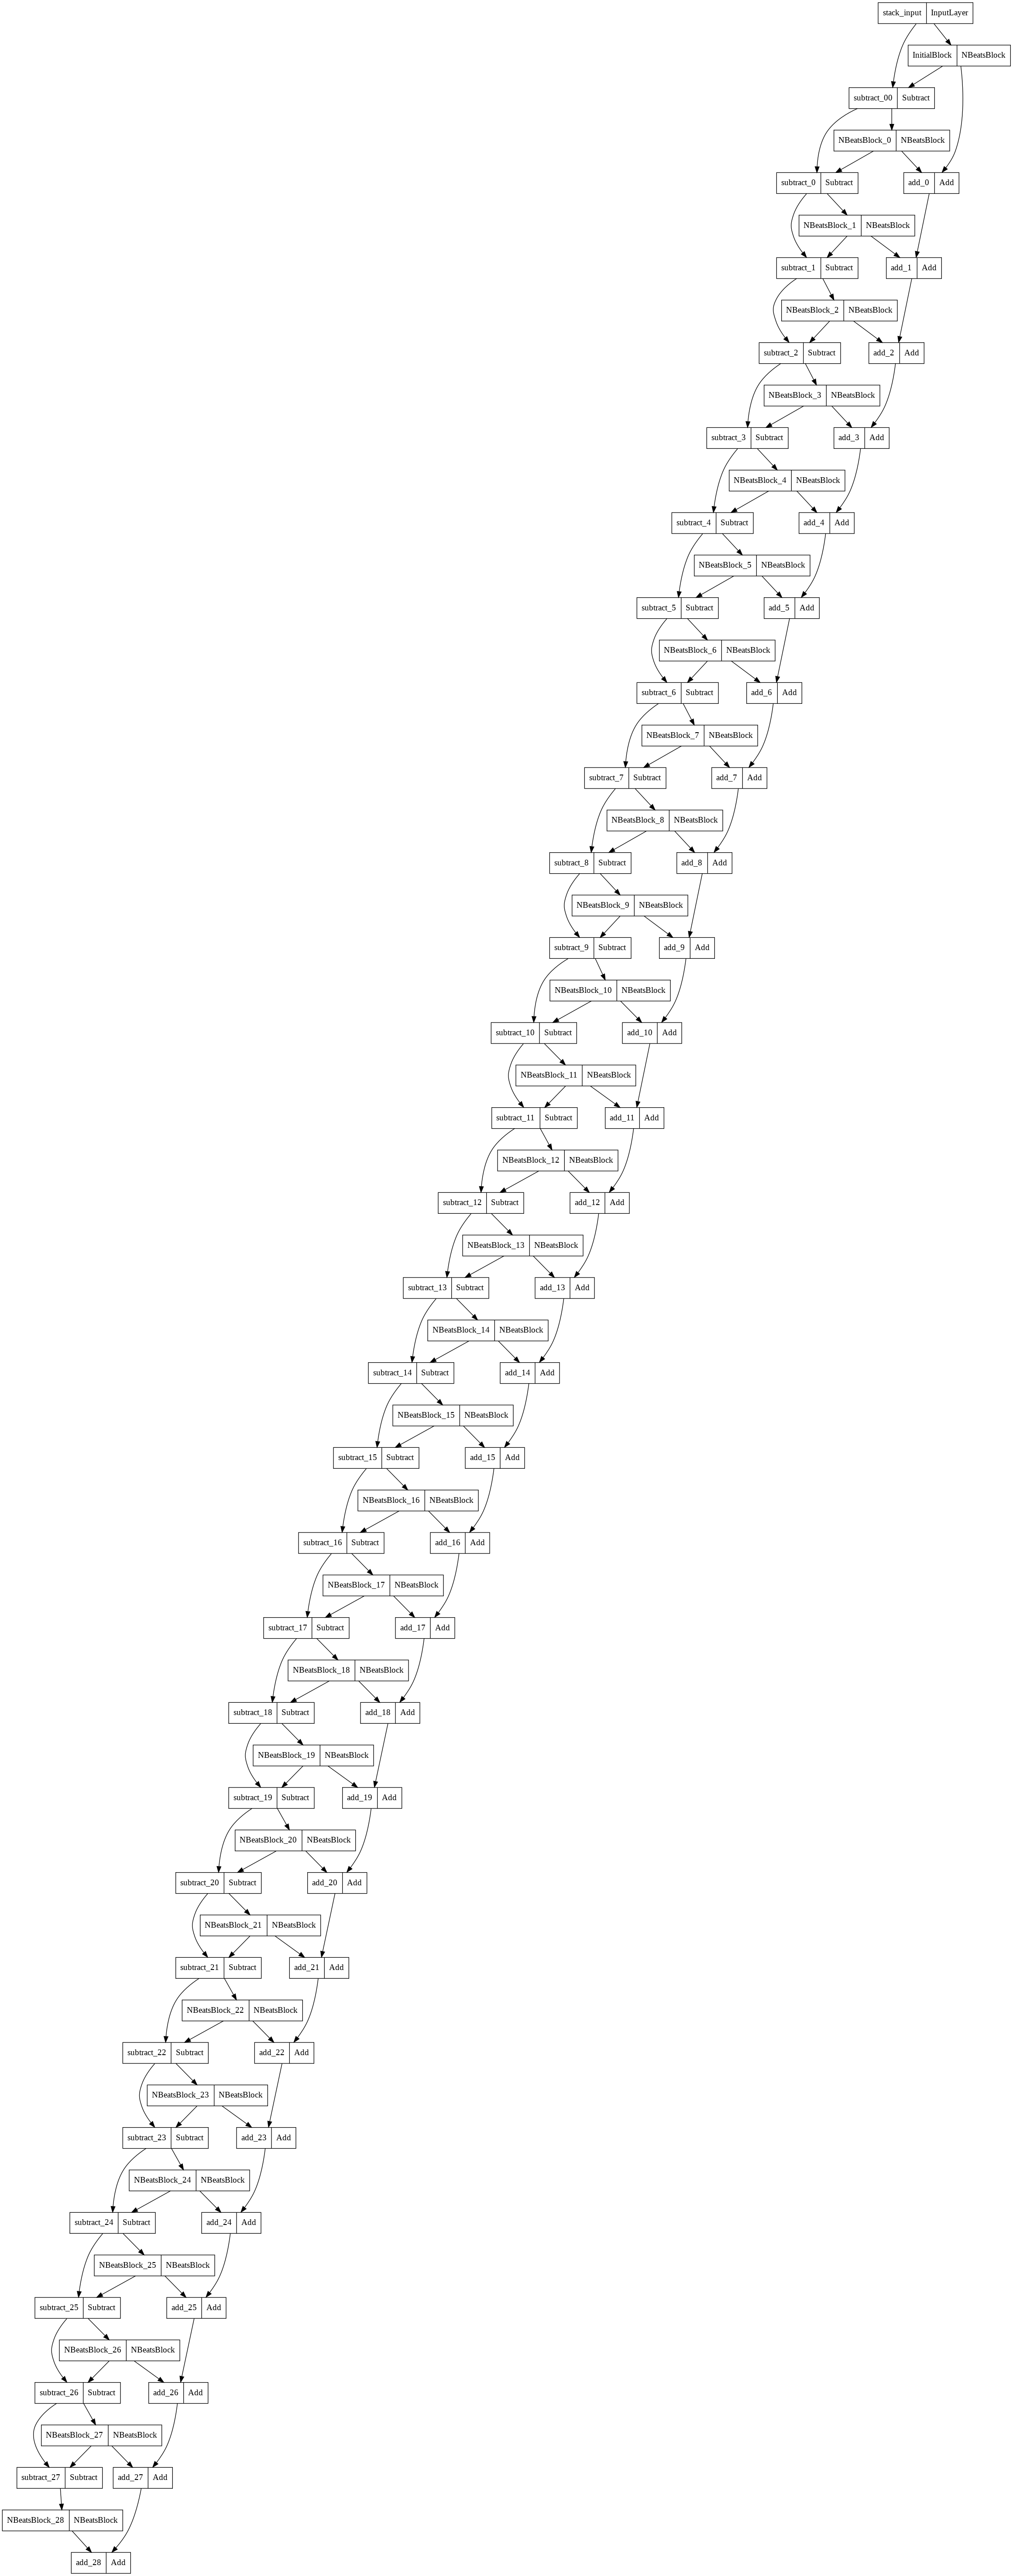

In [ ]:
### Plotting the N-BEATS architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (multiple models stacked together)

An ensemble leverages the wisdom of the crowd effect.

It combines many different models to predict a common goal.

In [ ]:
HORIZON, WINDOW_SIZE

(1, 7)

### Constructing and fitting an ensemble of models (using differrent loss functions)

In [ ]:
def get_ensemble_models(horizon = HORIZON,
                        train_data = train_dataset,
                        test_data = test_dataset,
                        num_iter = 10,
                        num_epochs = 1000,
                        loss_fns = ["mae","mse","mape"]):
  
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter = 10, a list of 30 trained models will be returned:
  10 * len(["mae","mse","mape"]).
  """

  # Make empty list for trained ensemble
  ensemble_models = []

  # Create num_iter number of models
  for i in range(num_iter):
    # Build and fit a new model with
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          # Initialize dense layers with normal distribution for estimating prediction intervals later on
          layers.Dense(128, kernel_initializer = "he_normal", activation = "relu"),
          layers.Dense(128, kernel_initializer = "he_normal", activation = "relu"),
          layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss= loss_function,
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics = ["mae","mse"])
      
      # Fit the model
      model.fit(train_data,
                epochs = num_epochs,
                verbose = 0,
                validation_data = test_data,
                callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                              patience = 200,
                                                              restore_best_weights = True),
                              tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                                  patience = 100,
                                                                  verbose = 1)])
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

    return ensemble_models

In [ ]:
%%time

# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter = 5,
                                      num_epochs = 1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 746: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 965: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 642: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 758: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 858: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 168: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 268: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 56.9 s, sys: 4.83 s, total: 1min 1s
Wall time: 55.4 s


In [ ]:
len(ensemble_models)

3

In [ ]:
ensemble_models

### Make predictions with out ensemble model

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predicitons
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of enseumble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models = ensemble_models,
                                     data = test_dataset)
ensemble_preds

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 339ms/step
CPU times: user 413 ms, sys: 33.6 ms, total: 447 ms
Wall time: 456 ms


<tf.Tensor: shape=(3, 556), dtype=float32, numpy=
array([[ 8806.31 ,  8777.225,  9022.009, ..., 50126.07 , 49102.066,
        46784.89 ],
       [ 8763.87 ,  8742.891,  9057.533, ..., 49404.684, 48511.27 ,
        45339.234],
       [ 8745.424,  8733.034,  9101.386, ..., 49267.164, 47660.426,
        45370.047]], dtype=float32)>

In [ ]:
ensemble_preds

<tf.Tensor: shape=(3, 556), dtype=float32, numpy=
array([[ 8806.31 ,  8777.225,  9022.009, ..., 50126.07 , 49102.066,
        46784.89 ],
       [ 8763.87 ,  8742.891,  9057.533, ..., 49404.684, 48511.27 ,
        45339.234],
       [ 8745.424,  8733.034,  9101.386, ..., 49267.164, 47660.426,
        45370.047]], dtype=float32)>

In [ ]:
y_test

Date
2019-11-10     8798.042055
2019-11-11     9081.186878
2019-11-12     8711.534339
2019-11-13     8760.892718
2019-11-14     8749.520591
                  ...     
2021-05-14    49764.132082
2021-05-15    50032.693137
2021-05-16    47885.625255
2021-05-17    45604.615754
2021-05-18    43144.471291
Name: Price, Length: 556, dtype: float64

**Note** Running tf calls in a for loop can cause a slowdown

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true = y_test,
                                  y_pred = ensemble_preds)
ensemble_results

{'mae': 581.2807,
 'mse': 1205875.0,
 'rmse': 1098.0859,
 'mape': 2.6805732,
 'mase': 1.0211492}

Our ensemble preds come out in multiple dimensions but to combine into **point predictions** we can leverage the mean of all of the predicitons or the median - https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis = 0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8771.868 , 8751.05  , 9060.31  , 8734.961 , 8749.842 , 8686.6045,
       8664.79  , 8469.1045, 8450.337 , 8527.728 ], dtype=float32)>

In [ ]:
ensemble_median = np.median(ensemble_preds, axis = 0)
ensemble_median

array([ 8763.87  ,  8742.891 ,  9057.533 ,  8718.841 ,  8732.885 ,
        8677.362 ,  8676.42  ,  8478.887 ,  8452.726 ,  8518.141 ,
        8200.059 ,  8082.363 ,  8014.7397,  7585.0864,  7263.7534,
        7280.509 ,  7071.566 ,  7217.901 ,  7081.1387,  7580.8506,
        7361.685 ,  7785.9272,  7575.1577,  7395.9087,  7336.7495,
        7311.715 ,  7193.033 ,  7405.689 ,  7491.701 ,  7537.452 ,
        7551.769 ,  7318.2896,  7217.7534,  7168.4116,  7191.4126,
        7251.8115,  7087.0776,  7111.363 ,  6846.18  ,  6572.864 ,
        7407.856 ,  7139.263 ,  7196.572 ,  7257.4375,  7318.305 ,
        7229.7837,  7216.7686,  7203.864 ,  7180.084 ,  7213.725 ,
        7301.7954,  7382.6743,  7246.237 ,  7177.162 ,  7166.907 ,
        6936.712 ,  7276.96  ,  7306.35  ,  7383.469 ,  7728.69  ,
        8055.687 ,  8121.951 ,  7878.662 ,  8127.006 ,  8112.5483,
        8172.3784,  8111.22  ,  8772.674 ,  8878.075 ,  8739.588 ,
        8987.4795,  8963.133 ,  8657.597 ,  8630.657 ,  8682.2

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

Right now all of our model's (prior to the ensemble model) are predicting single points.

Meaning, given a set of WINDOW_SIZE=7 values, the model will predict HORIZION=1.

But what might be more helpful than a single value?

Perhaps a range of values?

For example, if a model is predicting the price of Bitcoin to be 50,000USD tomorrow, would it be helpful to know it's predicting the 50,000USD because it's predicting the price to be between 48,000 and 52,000USD? (note: "$" has been omitted from the previous sentence due to formatting issues)

Knowing the range of values a model is predicting may help you make better decisions for your forecasts.

You'd know that although the model is predicting 50,000USD (a point prediction, or single value in time), the value could actually be within the range 48,000USD to 52,000USD (of course, the value could also be outside of this range as well, but we'll get to that later).

These kind of prediction ranges are called prediction intervals or uncertainty estimates. And they're often as important as the forecast itself.

Why?

Because point predictions are almost always going to be wrong. So having a range of values can help with decision making.

 Resource(s):

    The steps we're about to take have been inspired by the Machine Learning Mastery blog post Prediction Intervals for Deep Learning Neural Networks. Check out the post for more options to measure uncertainty with neural networks.
    For an example of uncertainty estimates being used in the wild, I'd also refer to Uber's Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber blog post.


In [ ]:
# Evaluate ensemble model predictions by the mean across the 15 models
ensemble_results = evaluate_preds(y_true = y_test,
                                  y_pred = ensemble_mean)
ensemble_results

{'mae': 571.59686,
 'mse': 1177325.4,
 'rmse': 1085.0463,
 'mape': 2.6238363,
 'mase': 1.0041374}

https://www.wikipedia.org/wiki/1.96
https://eng.uber.com/neural-networks-uncertainty-estimation/
---



In [ ]:
preds[0]

NameError: ignored

In [ ]:
# Find upper and lower bounds of ensemble predicitons
def get_upper_lower(preds): # 1. Take the predicitons from a number of randomly initialized deep learning neural networks

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis = 0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis = 0)
  lower, upper = preds_mean - interval, preds_mean
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)

In [ ]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis = 0)

# Plot the median of our ensemble preds along with the prediciotn intervals (where the upper and lower bounds)




Wonderful, now we've got the upper and lower bounds for the the 95% prediction interval, let's plot them against our ensemble model's predictions.

To do so, we can use our plotting function as well as the matplotlib.pyplot.fill_between() method to shade in the space between the upper and lower bounds.


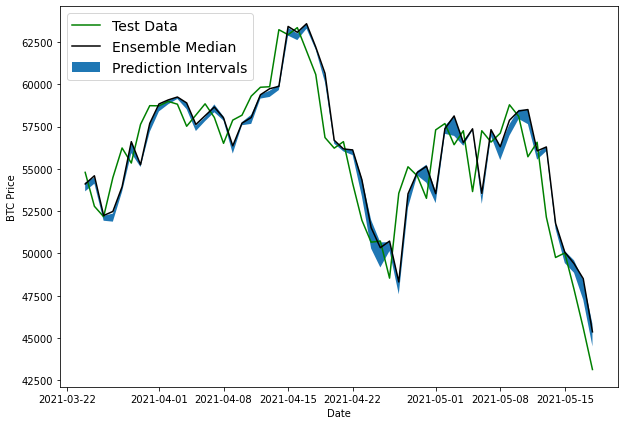

In [ ]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# To plpot the upper and lower bounds, use fill between
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);




We've just plotted:

- The test data (the ground truth Bitcoin prices)
- The median of the ensemble predictions
-The 95% prediction intervals (assuming the data is Gaussian/normal, the model is saying that 95% of the time, predicted value should fall between this range)

What can you tell about the ensemble model from the plot above?

It looks like the ensemble predictions are lagging slightly behind the actual data.

And the prediction intervals are fairly low throughout.

The combination of lagging predictions as well as low prediction intervals indicates that our ensemble model may be **overfitting** the data, meaning it's basically replicating what a naïve model would do and just predicting the previous timestep value for the next value.

This would explain why previous attempts to beat the naïve forecast have been futile.

We can test this hypothesis of overfitting by creating a model to make predictions into the future and seeing what they look like.

    🔑 Note: Our prediction intervals assume that the data we're using come from a Gaussian/normal distribution (also called a bell curve), however, open systems rarely follow the Gaussian. We'll see this later on with the turkey problem 🦃. For further reading on this topic, I'd recommend reading The Black Swan by Nassim Nicholas Taleb, especially Part 2 and Chapter 15.



## Model 10: Why forecasting is BS (the turkey problem)

In [ ]:
# Lte's introduce a turkey problem to our BTC data (price of BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
len(btc_price_turkey)

2787

In [ ]:
# Manufacture an extra price on the end (to showcase our Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [ ]:
# Get the timesteps for the turkey problem 
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

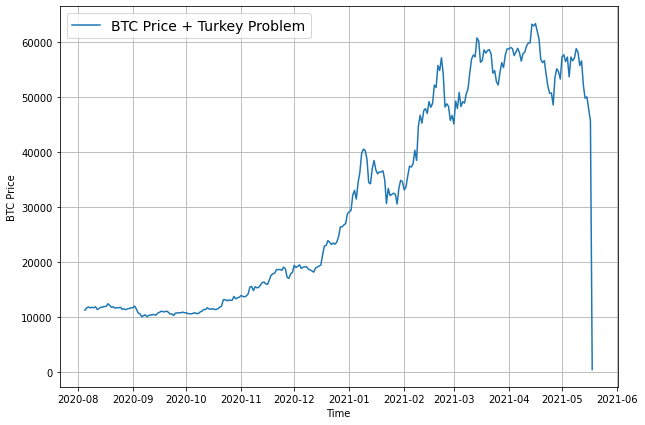

In [ ]:
# Create turkeu problem plot
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey, 
                 values=btc_price_turkey, 
                 format="-", 
                 label="BTC Price + Turkey Problem", 
                 start=2500)


In [ ]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

Window indexes:
 (array([[   0,    1,    2, ...,    5,    6,    7],
       [   1,    2,    3, ...,    6,    7,    8],
       [   2,    3,    4, ...,    7,    8,    9],
       ...,
       [2777, 2778, 2779, ..., 2782, 2783, 2784],
       [2778, 2779, 2780, ..., 2783, 2784, 2785],
       [2779, 2780, 2781, ..., 2784, 2785, 2786]]), (2780, 8))


(2224, 556, 2224, 556)

In [ ]:
### Build a turkey model (to predict on turkey data)

In [ ]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [ ]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 746.5820


746.58203125

In [ ]:
# Load best model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model/")
turkey_model.evaluate(X_test, y_test)


18/18 [==============================] - 0s 5ms/step - loss: 639.4670


639.4669799804688

In [ ]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8835.723, 8788.288, 9053.451, 8754.59 , 8745.671, 8746.48 ,
       8676.796, 8529.077, 8456.494, 8539.924], dtype=float32)>

In [ ]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results


{'mae': 17148.986,
 'mse': 615717900.0,
 'rmse': 23748.89,
 'mape': 121.62549,
 'mase': 26.53811}

And with just one value change, our error metrics go through the roof.

To make sure, let's remind ourselves of how model_1 went on unmodified Bitcoin data (no turkey problem).


In [ ]:
model_1_results


{'mae': 568.95105,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

By changing just one value, the turkey_model MAE increases almost 30x over model_1.

Finally, we'll visualize the turkey predictions over the test turkey data.


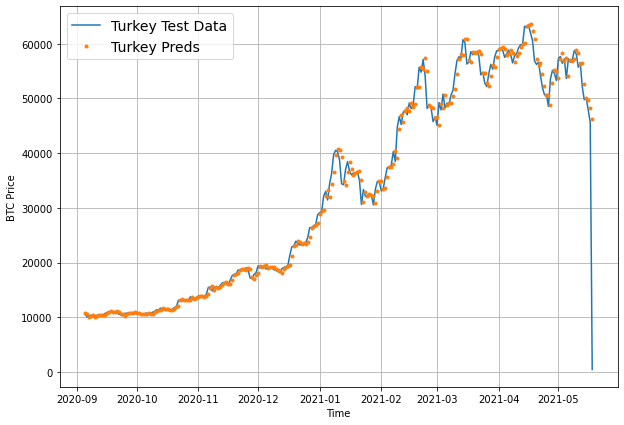

In [ ]:
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=btc_timesteps_turkey[:split_size], values=btc_price_turkey[:split_size], label="Train Data")
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):], 
                 values=btc_price_turkey[-len(y_test):], 
                 format="-", 
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds, 
                 label="Turkey Preds", 
                 start=offset);

Why does this happen?

Why does our model fail to capture the turkey problem data point?

Think about it like this, just like a turkey who lives 1000 joyful days, based on observation alone has no reason to believe day 1001 won't be as joyful as the last, a model which has been trained on historical data of Bitcoin which has no single event where the price decreased by 100x in a day, has no reason to predict it will in the future.

A model cannot predict anything in the future outside of the distribution it was trained on.

In turn, highly unlikely price movements (based on historical movements), upward or downward will likely never be part of a forecast.

However, as we've seen, despite their unlikeliness, these events can have huuuuuuuuge impacts to the performance of our models.

    📖 Resource: For a great article which discusses Black Swan events and how they often get ignored due to the assumption that historical events come from a certain distribution and that future events will come from the same distribution see Black Swans, Normal Distributions and Supply Chain Risk by Spend Matters.



This is why forecasting is BS!